# Stellar-to-Subhalo-Mass Relation for LSBGs

## Introduction

The stellar-to-halo mass relation (SHMR) links dark matter halos to their resident galaxies, providing insight on galaxy formation and evolution. Faint or low-mass galaxies test the limits of the established, parameterized SHMR. In this notebook, we estimate the distribution of stellar masses for the red LSBG sample using the photometry and the color-mass-to-light relation. We compare this stellar mass to the subhalo mass gathered from the LSBG mass model and MCMC runs. We generate a parameterized version of the stellar-to-halo-mass relation (for satellite galaxies) and compare the estimate to this curve. 

## Imports

* We use numpy for numerical calculations and analysis
* We use matplotlib for plotting
* We use scipy and random for statistical analysis
* We use seaborn to plot distributions
* We use pandas to load in files
* We use astropy for cosmology to calculate distances

In [195]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.stats import norm
from random import sample
import seaborn as sns
import pandas as pd
from astropy.cosmology import Planck15
from astropy import units as u
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Loading Data

We load in the LSBG catalog and pull out the positions, g-magnitudes, g-magnitude errors, i-magnitudes, i-magnitude errors, r-mangitudes, and r-magnitude errors. We create masks based on the color, red for $g-i>0.6$ and blue for $g-i<0.6$. We  apply the masks to obtain magnitudes for specific color samples. The majority of modeling for this notebook uses the g-band and i-band magnitudes and the red galaxy sample.

In [196]:
lens_file=pd.read_csv(r'../data/LSBG_catalog_v2.csv')
lens=pd.DataFrame(lens_file, columns= ['ra_se','dec_se', 'mag_gfm_g_corr', 'magerr_gfm_g', 'mag_gfm_i_corr','magerr_gfm_i', 'mag_gfm_r_corr','magerr_gfm_r','r_eff_r'])

In [197]:
g = lens['mag_gfm_g_corr']
g_err = lens['magerr_gfm_g']


In [4]:
i = lens['mag_gfm_i_corr']
i_err = lens['magerr_gfm_i']


In [5]:
r = lens['mag_gfm_r_corr']
r_err = lens['magerr_gfm_r']


In [6]:
mask_blue = (g-i)<=0.60
mask_red = (g-i)>=0.60
red_lens = lens[mask_red]
blue_lens = lens[mask_blue]


In [7]:
g_red = red_lens['mag_gfm_g_corr']
g_blue = blue_lens['mag_gfm_g_corr']
g_err_red = red_lens['magerr_gfm_g']
g_err_blue = blue_lens['magerr_gfm_g']


In [8]:
i_red = red_lens['mag_gfm_i_corr']
i_blue = blue_lens['mag_gfm_i_corr']
i_err_red = red_lens['magerr_gfm_i']
i_err_blue = blue_lens['magerr_gfm_i']


In [9]:
r_red = red_lens['mag_gfm_r_corr']
r_blue = blue_lens['mag_gfm_r_corr']
r_err_red = red_lens['magerr_gfm_r']
r_err_blue = blue_lens['magerr_gfm_r']

## Function Definitions

We define each of the functions used in this notebook, grouped here for ease of access. 

### Stellar Mass Functions

We build functions to calculate the distances to the galaxies, the absolute magnitudes, the colors, the mass-to-light ratios, the luminosities, and the stellar masses. We also include calculations for the propagated error of each of these values based on the uncertainties of the given apparent magnitudes. 

We calculate the distance to the LSBGs based on the mean lens redshift, given by the posterior of the MCMC, and the Planck15 cosmology. Note that we assumed a fixed redshift.

In [277]:
#Calculating distance to objects based on redshift (drawn from MCMC posterior)
def calculate_distance(zl_mean=None, zl_mean_err=None):
    """
    Calculates the angular diameter distance and the distance error based on the redshift
    
    zl_mean = mean lens redshift
    zl_mean_err = uncertainty of lens redshift
    
    """
    da = Planck15.comoving_distance(zl_mean)
    da_err = Planck15.comoving_distance(zl_mean_err)
    r_pc = np.array(da.to(u.parsec))
    r_pc_err = np.array(da_err.to(u.parsec)) 
    return r_pc, r_pc_err

We use the distance modulus to calculate the absolute magnitude of the LSBGs, based on the apparent magnitude and the distance: $$M_\mathrm{abs} = m_a - 5\log(r/10).$$ $M_\mathrm{abs}$ represents the absolute magnitude, $m_a$ stands for the apparent magnitude, and $r$ indicates the distance (in parsecs). In addition, we propagate the error of the absolute magnitude forward from the distance and apparent magnitude uncertainties.

In [278]:
def absolute_magnitude(mag=None, distance=None, mag_err=None, distance_err=None):
    """
    Calculates the absolute magnitude of objects based on the distance and the apparent magnitude
    
    mag = apparent magnitude of object
    distance = distance to object (in parsecs)
    mag_err = magnitude uncertainty
    distance_err = distance uncertainty
    
    """
    M_abs = mag-(5*np.log10(distance/10))
    M_abs_err = np.sqrt(mag_err**2 + (distance_err**2)*((-5/(np.log(10)*distance))**2)) 
    return M_abs, M_abs_err

We calculate the color and the color error by finding the difference between two apparent magnitudes (as $m_{a1}-m_{a2}$) and propagating the apparent magnitude uncertainty forward. 

In [279]:
#Caculating color and color error
def color_func(mag_1=None, mag_2=None, mag_1_err=None, mag_2_err=None):
    """
    Calculates the color and the color uncertainty between two magnitude bands
    
    mag_1 = band 1 (usually g)
    mag_2 = band 2 (usually i or r)
    mag_1_err = uncertainty in band 1
    mag_2_err = uncertainty in band 2
    
    """
    color = mag_1-mag_2
    color_err = np.sqrt(mag_1_err**2 + mag_2_err**2) 
    return color, color_err

We use the mass-to-light color relation (MLCR), as developed in Bell et al. 2003, to calculate the mass-to-light ratio for the LSBGs:$$\log \gamma_* = a_\lambda + (b_\lambda \times \mathrm{color}).$$ $\gamma_*$ represents the mass-to-light ratio, $a_\lambda$ signifies the zeropoint of the MLCR, $b_\lambda$ designates the slope of the MLCR, and $\mathrm{color}$ stands for the selected color band. We propagate the color error forward from the apparent magnitudes to calculate the mass-to-light ratio uncertainty.

In [201]:
def MLCR(a=None, b=None, color=None, color_err=None): 
    """
    Calculates the mass-to-light ratio and the mass-to-light ratio uncertainty based on the color and the factors of Bell et al. 2003
    
    a = color-mass light ratio model parameter from Bell et al. 2003
    b = color-mass light ratio model parameter from Bell et al. 2003
    color = color (g-r or g-i)
    color_err = uncertainty of color
    
    """
    m_l_ratio = 10**(a + b * (color))
    m_l_ratio_err = np.sqrt((np.log(10)*10**(a+b*color)*b)**2 * color_err**2) #Propagated error 
    return m_l_ratio, m_l_ratio_err

We compare the absolute magnitudes of the LSBGs in a specified band to the absolute magnitude of the sun to calculate the luminosity: $$L = 10^{0.4 \times (M_{j, \odot} - M_{j,\mathrm{abs}})}.$$ $L$ represents the luminosity, $M_{j, \odot}$ signifies the solar luminosity in the specified band, and $M_{j, \mathrm{abs}}$ indicates the absolute magnitude of the object in the specified band. We propagate the absolute magnitude uncertainty forward to extract the luminosity error.

In [280]:
def lum_func(m_sol=None, m_abs=None, m_abs_err=None):
    """
    Calculates the luminosity and the luminosity uncertainty by comparing an object's absolute magnitude to the solar absolute magnitude
    
    m_sol = solar luminosity/absolute magnitude in selected band
    m_abs = absolute magnitude of object in selected band
    m_abs_err = uncertainty of absolute magnitude of object in selected band 
    
    """
    lum = 10**(0.4*(m_sol-m_abs))
    lum_err = np.sqrt((np.log(10)*(-0.4)*10**(0.4*(m_sol - m_abs)))**2 * (m_abs_err)**2) #Propagated error
    return lum, lum_err

We multiply the mass-to-light ratio (obtained from the MLCR) by the luminosity to extract the stellar mass: $$M_* = L\times \gamma_*.$$ We propagate forward the uncertaintieis of the mass-to-light ratio and the luminosity. 

In [281]:
def stellar_mass(m_l_ratio=None, lum=None, m_l_ratio_err=None, lum_err=None):
    """
    Calculates the stellar mass and the stellar mass uncertainty by comparing the mass-to-light ratio to the luminosity
    
    m_l_ratio = mass-to-light ratio
    lum = object luminosity
    m_l_ratio_err = mass-to-light ratio uncertainty
    lum_err = luminosity uncertainty
    
    """
    m_stellar = m_l_ratio*lum
    m_stellar_err = np.sqrt(((lum)**2 * (m_l_ratio_err)**2)+ ((m_l_ratio)**2 * lum_err**2)) #Propagated error 
    return m_stellar, m_stellar_err

We divide the stellar mass by the halo mass to calculate the SHMR and the SHMR uncertainty, as $M_*/M_h$

In [282]:
def shmr_func(m_halo=None, m_halo_err=None, m_stellar=None, m_stellar_err=None):
    """
    Calculates the stellar-to-halo mass relation and uncertainty
    
    m_halo = halo mass
    m_halo_err = halo mass uncertainty
    m_stellar = stellar mass
    m_stellar_err = stellar mass uncertainty
    
    """
    shmr = m_stellar/m_halo
    shmr_err = np.sqrt(((1/m_halo)**2 * (m_stellar_err)**2) + ((-m_stellar/m_halo**2)**2)*(m_halo_err)**2)
    return shmr, shmr_err

We combine the previous functions to produce a stellar mass and a stellar-halo-mass relation for LSBGs based on the photometry and the lens redshift.

In [283]:
def total_shmr(zl_mean=None, zl_mean_err=None, mag=None, mag_err=None, mag_1=None, 
               mag_1_err=None, mag_2=None, mag_2_err=None, a=None, b=None, m_sol=None, m_halo=None, m_halo_err=None):
    """
    Calculates the stellar mass and the stellar-halo-mass relation in one call, based on the photometry
    
    zl_mean = mean lens redshift
    zl_mean_err = mean lens redshift uncertainty
    mag = magnitude band
    mag_err = uncertainty of magnitude
    mag_1 = magnitude band used to calculate color (usually g)
    mag_1_err = uncertainty of mag_1
    mag_2 = magnitude band used to calculate color (usually r or i)
    mag_2_err = uncertainty of mag_2
    a = zeropoint parameter for MLCR, dependent on band
    b = slope parameter for MLCR, dependent on band
    m_sol = solar absolute magnitude, dependent on band
    m_halo = halo mass
    m_halo_err = halo mass uncertainty
    
    """
    distance, distance_err = calculate_distance(zl_mean=zl_mean, zl_mean_err=zl_mean_err)
    M_abs, M_abs_err = absolute_magnitude(mag=mag, distance=distance, mag_err=mag_err, distance_err=distance_err)
    color, color_err = color_func(mag_1=mag_1, mag_2=mag_2, mag_1_err=mag_1_err, mag_2_err=mag_2_err)
    m_l_ratio, m_l_ratio_err = MLCR(a=a, b=b, color=color, color_err=color_err)
    lum, lum_err = lum_func(m_sol=m_sol, m_abs=M_abs, m_abs_err=M_abs_err)
    m_stellar, m_stellar_err = stellar_mass(m_l_ratio=m_l_ratio, lum=lum, m_l_ratio_err=m_l_ratio_err, lum_err=lum_err)
    shmr, shmr_err = shmr_func(m_halo=m_halo, m_halo_err=m_halo_err, m_stellar=m_stellar, m_stellar_err=m_stellar_err)
    return m_stellar, m_stellar_err, shmr, shmr_err


### Parameterized Subhalo-Stellar Mass Relation Functions

We examine the parameterized stellar-to-subhalo-mass relation (SsHMR), as defined in Niemec et al (2022). The parameterized SsHMR relies on 4 different parameters, in addition to the subhalo mass ($M_h$): the characteristic halo mass ($M_\mathrm{char}$), the normalization of the SsHMR at the characteristic halo mass ($A$), the slope at the low-mass end of the relation ($\beta$) and the slope at the high-mass end of the relation ($\gamma$). The full relation is defined as: $$\frac{M_*}{M_h} = 2 \times A \times ((\frac{M_h}{M_\mathrm{char}})^{-\beta} + (\frac{M_h}{M_\mathrm{char}})^\gamma)^{-1} $$ We define a function to calculate the SsHMR based on these parameters. 

In [284]:
def parameterized_sshmr(m_halo=None, A=None, M_char=None, beta=None, gamma=None):
    """
    Calculates the SsHMR based on 4 parameters and the halo mass
    
    m_halo = halo mass
    A = normalization of the SHMR at the characteristic halo mass
    M_char = characteristic halo mass
    beta = slope of relation at low-mass end
    gamma = slope of relation at high-mass end
    
    """
    m_stellar_param = 2*A*m_halo*(((m_halo/M_char)**(-1*beta) + (m_halo/M_char)**gamma)**(-1))
    return m_stellar_param

### Resampling Error Functions

We define a function to resample the magnitudes to examine the impact of the measured magnitude uncertainty. 

In [285]:
def sampled_mag(magnitude=None, magnitude_err=None):
    """
    Resamples the magnitudes over the band uncertainty
    magnitude = selected band magnitude
    magnitude_err = selected band magnitude uncertainty
    
    """
    sampled_magnitudes = []
    for mag, error in zip(magnitude, magnitude_err):
        sampled_magnitude = np.random.normal(loc=mag, scale=error)
        sampled_magnitudes.append(sampled_magnitude)
    return sampled_magnitudes


We define a function to resample the stellar masses to examine their spread and the impact of the measured magnitude uncertainty.

In [286]:
def m_stellar_resampled(sampled_magnitudes=None, mag_err=None, distance=None, distance_err=None,
                        m_sol=None, a=None, b=None, color=None, color_err=None):
    """
    Resamples stellar mass over magnitude band uncertainty
    
    sampled_magnitudes = array of resampled band magnitudes
    mag_err = band magnitude uncertainty
    distance = distance to objects
    distance_err = distance uncertainty
    m_sol = solar luminosity/absolute magnitude in selected band
    a = zeropoint of MLCR
    b = slope of MLCR
    color = selected color
    color_err = color uncertainty
    
    """
    abs_mag_sampled, abs_mag_err_sampled = absolute_magnitude(mag=sampled_magnitudes, distance=distance, mag_err=mag_err, distance_err=distance_err)
    lum_mag_sampled, lum_mag_err_sampled = lum_func(m_sol=m_sol, m_abs = abs_mag_sampled, m_abs_err = abs_mag_err_sampled)
    ml_ratio, ml_ratio_err = MLCR(a=a, b=b, color=color, color_err=color_err)
    m_stellar_sampled, m_stellar_err_sampled = stellar_mass(m_l_ratio=ml_ratio, lum=lum_mag_sampled, m_l_ratio_err = ml_ratio_err, lum_err = lum_mag_err_sampled)
    return m_stellar_sampled, m_stellar_err_sampled

We define a function to resample the SsHMR parameters around their uncertainties. We construct a stellar mass estimate based on this resampling.

In [287]:
def sshmr_param_resampled(A=None, A_err=None, M_char=None, M_char_err=None, 
                          beta=None, beta_err = None, gamma=None, gamma_err=None, halo_mass_range = None):
    """
    Resamples the stellar-halo mass relation over the parameter uncertainties
    
    A = normalization of SHMR at characteristc halo mass
    A_err = uncertainty of A
    M_char = characteristic halo mass
    M_char_err = uncertainty of M_char
    beta = slope of relation at low-mass end
    beta_err = uncertainty of beta
    gamma = slope of relation at high-mass end
    gamma_err = uncertainty of gamma
    halo_mass_range = discrete range of halo masses to calculate sshmr over
    
    """
    sampled_stellar_mass = []
    for i, xi in enumerate(halo_mass_range):
        for y in range(10000):
            A_samp = np.random.normal(loc=A, scale=A_err)
            M_char_samp = np.random.normal(loc=M_char, scale=M_char_err)
            beta_samp = np.random.normal(loc=beta, scale=beta_err)
            gamma_samp = np.random.normal(loc=gamma, scale=gamma_err)
            stellar_mass_samp = parameterized_sshmr(m_halo=xi, A=A_samp, M_char=M_char_samp, beta=beta_samp, gamma=gamma_samp)
            sampled_stellar_mass.append(stellar_mass_samp)
    sampled_stellar_mass = np.reshape(sampled_stellar_mass, (len(halo_mass_range), 10000))
    return sampled_stellar_mass
        

We define a function to identify the spread of the SsHMR based on the resampled parameters.

In [288]:
def sshmr_spread(halo_mass_range=None, sampled_mstellar_sshmr=None):
    """
    Calculates the spread of the SSHMR relation based on the parameter uncertainties
    
    halo_mass_range = discrete range of halo masses to calculate the spread over
    sampled_mstellar_sshmr = resampled stellar mass over SSHMR parameter uncertainties
    
    """
    
    spread_mstellar_list = []
    spread_sshmr_list = []
    for i, xi in enumerate(halo_mass_range):
        spread_obj_mstellar = [np.min(sampled_mstellar_sshmr[i,:]), np.max(sampled_mstellar_sshmr[i,:])]
        spread_obj_sshmr = [np.min(sampled_mstellar_sshmr[i,:])/xi, np.max(sampled_mstellar_sshmr[i,:])/xi]
        spread_mstellar_list.append(spread_obj_mstellar)
        spread_sshmr_list.append(spread_obj_sshmr)
    spread_mstellar_arr = np.array(spread_mstellar_list)
    spread_sshmr_arr = np.array(spread_sshmr_list)
    return spread_mstellar_arr, spread_sshmr_arr

## Parameters

### Stellar Mass Parameters

We define the parameters used to determine the stellar mass. The mean lens redshift and lens redshift error are adopted from the posterior of an MCMC, calculated for the red LSBG sample. We use the designated a and b values (drawn from Bell et al. 2003) for the color mass-to-light relation, defined for the color *g-i*. We define the AB absolute magnitude of the sun for a specific SDSS filter. In addition, we define the subhalo mass estimate and subhalo mass uncertainty used to calculate the LSBG SHMR.

In [259]:
zl_mean = 0.0142
zl_mean_err = 0.0018
#Bell 2003, Wei 2020
a_i = -0.152 #-0.993 #(g-i)
b_i =  0.518 #1.057
m_sol_i = 4.54

a_g =  -0.379 #-1.152 #(g-i)
b_g =  0.914 #1.328
m_sol_g = 5.14

a_r =  -0.220 #-0.947 #(g-i)
b_r =  0.661 #1.088
m_sol_r = 4.65

m_halo = 3.1e11
m_halo_err = 1.1e11
m_halo_arr = np.linspace(1e10, 1e12, 10000)

We define additional parameters for the MLCR for the color *g-r*.

In [260]:
a_i_gr =  -0.222 #-0.756 #(g-r)
b_i_gr =  0.864 #1.226

a_g_gr =  -0.499 #-0.857 #(g-r)
b_g_gr =  1.519 #1.558

a_r_gr =  -0.306 #-0.700 #(g-r)
b_r_gr =  1.097 #1.252

### SsHMR Parameters

We define the parameters necessary for the subhalo-stellar-mass relation, drawn from Niemiec et al 2022. These parameters are redshift dependent, thus we select the parameters designed for low-redshift galaxies. 

In [261]:
#Moster 2018, Niemec 2022
A = 0.0186 #0.056
A_err = 0.0012 #0.005

M_char = 10**(12.1988) #10**(11.14)
M_char_err = 10**(0.0878) #10**0.09

beta = 0.7817 #1.24
beta_err = 0.0629 #0.13

gamma = 0.7334 #0.35
gamma_err = 0.0452 #0.07

We define a continuous and a discrete array of halo masses to plot the parameterized SsHMR.

In [262]:
m_halo_arr_cont = np.linspace(5e10, 1e13, 10000)
halo_mass_range = np.array([5e10, 6e10, 7e10, 8e10, 9e10, 1e11, 2e11, 3e11, 4e11, 5e11, 6e11, 7e11, 8e11, 9e11, 1e12, 2e12, 3e12, 4e12, 5e12, 6e12, 7e12, 8e12, 9e12, 1e13])

## LSBG Stellar Mass

We call the functions to estimate the LSBG stellar mass for a range of colors and magnitude bands, illustrating that the stellar mass estimate remains consistent. In addition, we resample the magnitude and the stellar mass based on the magnitude uncertainty.

We estimate the stellar mass for the i-band, g-band, and r-band with the color g-i.

In [263]:
#For color g-i
m_stellar_i_red, m_stellar_err_i_red, shmr_i_red, shmr_err_i_red = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag=i_red, mag_err = i_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=i_red, mag_2_err=i_err_red, a=a_i, b=b_i, m_sol=m_sol_i, m_halo = m_halo, m_halo_err=m_halo_err)

m_stellar_g_red, m_stellar_err_g_red, shmr_g_red, shmr_err_g_red = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag = g_red, mag_err = g_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=i_red, mag_2_err=i_err_red, a=a_g, b=b_g, m_sol=m_sol_g, m_halo = m_halo, m_halo_err=m_halo_err)

m_stellar_r_red, m_stellar_err_r_red, shmr_r_red, shmr_err_r_red = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag = r_red, mag_err = r_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=i_red, mag_2_err=i_err_red, a=a_r, b=b_r, m_sol=m_sol_r, m_halo = m_halo, m_halo_err=m_halo_err)


In [264]:
print(np.median(m_stellar_i_red), np.median(m_stellar_g_red), np.median(m_stellar_r_red))

68234196.19422778 69805088.47555813 68756829.42064649


We observe that the stellar mass estimates remain reasonably consistent, even with the use of different magnitude bands. We continue our testing with the colorband *g-r*.

We estimate the stellar mass for the i-band, g-band, and r-band with the color g-r.

In [265]:
#For color g-r
m_stellar_i_red_gr, m_stellar_err_i_red_gr, shmr_i_red_gr, shmr_err_i_red_gr = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag=i_red, mag_err = i_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=r_red, mag_2_err=r_err_red, a=a_i_gr, b=b_i_gr, m_sol=m_sol_i, m_halo = m_halo, m_halo_err=m_halo_err)

m_stellar_g_red_gr, m_stellar_err_g_red_gr, shmr_g_red_gr, shmr_err_g_red_gr = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag = g_red, mag_err = g_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=r_red, mag_2_err=r_err_red, a=a_g_gr, b=b_g_gr, m_sol=m_sol_g, m_halo = m_halo, m_halo_err=m_halo_err)

m_stellar_r_red_gr, m_stellar_err_r_red_gr, shmr_r_red_gr, shmr_err_r_red_gr = total_shmr(zl_mean=zl_mean, zl_mean_err=zl_mean_err, mag = r_red, mag_err = r_err_red, mag_1= g_red, 
               mag_1_err=g_err_red, mag_2=r_red, mag_2_err=r_err_red, a=a_r_gr, b=b_r_gr, m_sol=m_sol_r, m_halo = m_halo, m_halo_err=m_halo_err)


In [266]:
print(np.median(m_stellar_i_red_gr), np.median(m_stellar_g_red_gr), np.median(m_stellar_r_red_gr))

71100088.92166919 75256340.99912351 72596995.25368276


Color appears to have a more significant impact than simply using different bands, though the estimates are still comparable. 

We resample the i-band magnitudes over the magnitude uncertainty and plot their spread.

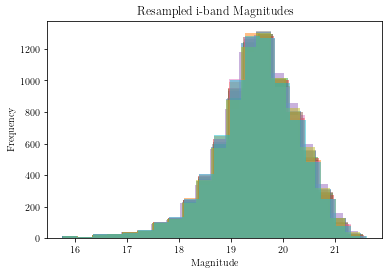

In [267]:
for i in range(10):
    mag_dist = sampled_mag(magnitude=i_red, magnitude_err=i_err_red)
    plt.hist(mag_dist, bins=20, alpha=0.5)
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Resampled i-band Magnitudes')
plt.show()

We resample the stellar mass over the i-band magnitude uncertainty with the color *g-i* and plot their spread. We see that the uncertainty in the magnitude does not significantly alter the stellar mass distribution, even when propagated through the calculations.

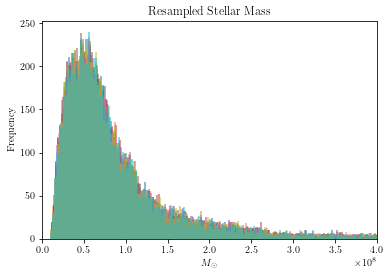

In [276]:
distance_resample, distance_err_resample = calculate_distance(zl_mean=zl_mean, zl_mean_err=zl_mean_err)
color_resample, color_err_resample = color_func(mag_1=g_red, mag_2=i_red, mag_1_err=g_err_red, mag_2_err=i_err_red)

for i in range(10):
    mag_dist = sampled_mag(magnitude=i_red, magnitude_err=i_err_red)
    m_stellar_dist, m_stellar_dist_err = m_stellar_resampled(sampled_magnitudes=mag_dist, mag_err=i_err_red, distance=distance_resample, distance_err=distance_err_resample, 
                                         m_sol=m_sol_i, a=a_i, b=b_i, color=color_resample, color_err=color_err_resample)
    plt.hist(m_stellar_dist, bins=1000, alpha=0.5)
plt.xlabel('$M_{\odot}$')
plt.ylabel('Frequency')
plt.xlim(0, 0.4e9)
plt.title('Resampled Stellar Mass')
plt.show()

## Parametrized Stellar-Subhalo Mass Relation

We call the functions to calculate and plot the parametrized stellar-subhalo mass relation. We compare the general stellar-subhalo mass relation to the LSBG stellar-halo mass relation. 

We produce an array of stellar masses from a continuous array of halo masses using the SsHMR. This generalized SsHMR mirrors Niemiec et al. 2022.

In [269]:
m_stellar_sshmr = parameterized_sshmr(m_halo=m_halo_arr_cont, A=A, M_char=M_char, beta=beta, gamma=gamma)

We calculate the stellar mass and the SsHMR for a discrete array of halo masses. We will use this list to evaluate the spread of the general SsHMR. 

In [270]:
stellar_mass_range_list = []
sshmr_list = []
for i, xi in enumerate(halo_mass_range):
    m_stellar_ex = parameterized_sshmr(m_halo = xi, A=A, M_char=M_char, beta=beta, gamma=gamma)
    sshmr_ex = m_stellar_ex/xi
    stellar_mass_range_list.append(m_stellar_ex)
    sshmr_list.append(sshmr_ex)

We resample the SsHMR stellar masses over the uncertainties in the parameters. 

In [271]:
sampled_stellar_mass_sshmr = sshmr_param_resampled(A=A, A_err=A_err, M_char=M_char, M_char_err=M_char_err, 
                          beta=beta, beta_err = beta_err, gamma=gamma, gamma_err=gamma_err, halo_mass_range = halo_mass_range)


We define the spread of the SsHMR using the resampled SsHMR stellar masses.

In [272]:
spread_mstellar_arr, spread_sshmr_arr = sshmr_spread(halo_mass_range=halo_mass_range, 
                                    sampled_mstellar_sshmr=sampled_stellar_mass_sshmr)


In [273]:
y_min_mstellar_spread = spread_mstellar_arr[:,0]
y_max_mstellar_spread = spread_mstellar_arr[:,1]

y_min_sshmr_spread = spread_sshmr_arr[:,0]
y_max_sshmr_spread = spread_sshmr_arr[:,1]

We plot the stellar mass as a function of halo mass for the parameterized SsHMR and compare to the stellar mass estimate for the red LSBGs.

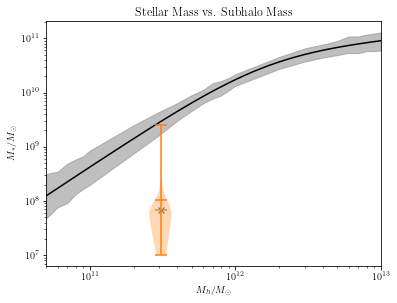

In [274]:
fig = plt.figure(figsize=(6,4.5))
plt.fill_between(halo_mass_range, y_min_mstellar_spread, y_max_mstellar_spread, color='grey', alpha=0.5)
plt.plot(m_halo_arr_cont, m_stellar_sshmr, color='black')
plt.plot(m_halo, np.median(m_stellar_i_red), marker='x')
plt.violinplot(m_stellar_i_red, positions=[m_halo], widths=1.1e11, showmeans=True, showmedians=True, vert=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_h/M_{\odot}$')
plt.ylabel('$M_*/M_{\odot}$')
plt.xlim(5e10, 1e13)
plt.title('Stellar Mass vs. Subhalo Mass')
plt.show()

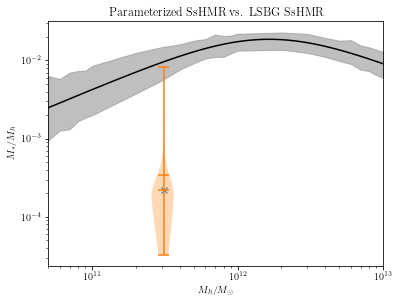

In [275]:
fig = plt.figure(figsize=(6,4.5))
plt.fill_between(halo_mass_range, y_min_sshmr_spread, y_max_sshmr_spread, color='grey', alpha=0.5)
plt.plot(m_halo_arr_param, m_stellar_sshmr/m_halo_arr_param, color='black')
plt.plot(m_halo, np.median(m_stellar_i_red)/m_halo, marker='x')
plt.violinplot(m_stellar_i_red/m_halo, positions=[m_halo], widths=1.1e11, showmeans=True, showmedians=True, vert=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$M_h/M_{\odot}$')
plt.ylabel('$M_*/M_h$')
plt.xlim(5e10, 1e13)
plt.title('Parameterized SsHMR vs. LSBG SsHMR')
plt.show()